In [56]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_lyapunov
import matplotlib.pyplot as plt

# Параметры объекта управления
a0 = -1
a1 = 1
b0 = 2

# Матрицы объекта управления
A = np.array([[0, 1],
              [-a0, -a1]])
b = np.array([[0.0],
              [b0]])

# Параметры эталонной модели (желаемое поведение)
am0, am1 = 256.0, 32.0
Am = np.array([[0, 1],
               [-am0, -am1]])
bm = np.array([[0.0],
               [am0]])

# Идеальные параметры регулятора
theta_ideal = np.array([[(a0 - am0)/b0],
                        [(a1 - am1)/b0]])

# Коэффициент усиления
kappa = b0 / am0

# Матрицы для уравнения Ляпунова
Q = np.eye(2)
P = solve_continuous_lyapunov(Am.T, -Q)

print("Параметры системы инициализированы:")
print(f"Объект управления: a0={a0}, a1={a1}, b0={b0}")
print(f"Эталонная модель: am0={am0}, am1={am1}")
print(f"Идеальные параметры: θ* = [{theta_ideal[0,0]:.1f}, {theta_ideal[1,0]:.1f}]")

Параметры системы инициализированы:
Объект управления: a0=-1, a1=1, b0=2
Эталонная модель: am0=256.0, am1=32.0
Идеальные параметры: θ* = [-128.5, -15.5]


In [ ]:
'ПРИБРАТЬСЯ В НАЗВАНИЯХ ДУБЛИРОВАННЫХ ФУНКЦИЙ!'


def get_g(t):
    return np.sign(np.sin(0.5 * t)) + 2

def control_u(x, theta_hat, g, kappa):
    """Закон управления: u = theta_hat^T * x + g/kappa"""
    result = theta_hat.T @ x + g / kappa
    return float(result[0, 0])  # Возвращаем скаляр


def get_u_not_adapt(x, theta, g, kappa):
    # Убедимся, что theta имеет правильную форму для умножения
    theta = theta.reshape(-1)  # преобразуем в одномерный массив формы (2,)
    
    # Вычисляем скалярное произведение для каждой строки x
    dot_product = np.sum(x * theta, axis=1)
    
    # Убедимся, что g имеет правильную форму
    if g.ndim > 1:
        g = g.flatten()
    
    return dot_product + g / kappa

def theta_hat_dot_func(x, xm, P, b):
    """Закон адаптации"""
    gamma = 1
    # e = xm - x
    e = x - xm
    # return gamma * x @ (b.T @ P @ e)
    return -gamma * x @ (b.T @ P @ e)


In [57]:
# Дополнительные вспомогательные функции

def get_y(C, x):
    """Выходной сигнал системы"""
    return C @ x

def get_x_dot(A, x, B, u):
    """Производная состояния объекта"""
    return A @ x + B @ u

def get_xm_dot(Am, xm, bm, g):
    """Производная состояния эталонной модели"""
    return Am @ xm + bm @ g

def closed_loop_adaptive(t, state):
    """
    Адаптивная замкнутая система
    state = [x(2), xm(2), theta_hat(2)]
    """
    x = state[0:2].reshape(2, 1)
    xm = state[2:4].reshape(2, 1)
    theta_hat = state[4:6].reshape(2, 1)

    g = get_g(t)
    u = control_u(x, theta_hat, g, kappa)

    x_dot = A @ x + b * u
    xm_dot = Am @ xm + bm * g
    theta_hat_dot = theta_hat_dot_func(x, xm, P, b)

    return np.vstack((x_dot, xm_dot, theta_hat_dot)).flatten()

print("Функции системы загружены")

Функции системы загружены


In [33]:
t_span = (0, 0.5)
t = np.linspace(t_span[0], t_span[1], 1000)
g = get_g(t)

# y0 = np.zeros(6)
# x = state[0:2].reshape(2, 1)
# xm = state[2:4].reshape(2, 1)
# # theta_hat = state[4:6].reshape(2, 1)


# get_xm_dot(Am, x, bm, g)

In [35]:
# начальные условия: все нули
y0 = np.zeros(6)
sol = solve_ivp(closed_loop, t_span, y0,
                method='RK45', max_step=0.01, dense_output=True)
Y = sol.sol(t).T    # shape: (N,6)

x = Y[:, 0:2]
xm = Y[:, 2:4]        
theta_hat = Y[:, 4:6]

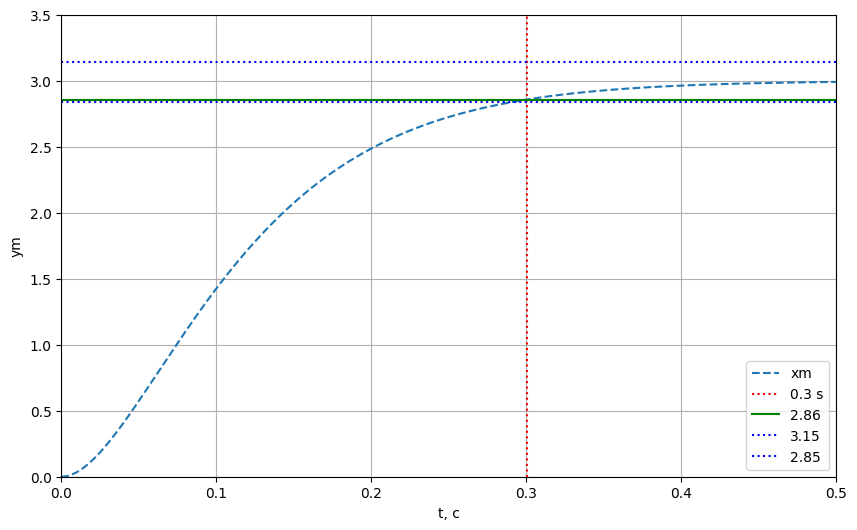

In [36]:
theta

Написать функцию для ВСВ и получения x по u
Построить график

# 2. Моделирование системы с неадаптивным регулятором

## 2.1 Эксперимент с расчетными (идеальными) параметрами

In [58]:
# Эксперимент 2.1: Используем идеальные параметры регулятора
theta_exp1 = np.array([theta_ideal[0, 0], theta_ideal[1, 0]])  # [-128.5, -15.5]

print("=== ЭКСПЕРИМЕНТ 2.1: ИДЕАЛЬНЫЕ ПАРАМЕТРЫ ===")
print(f"Параметры регулятора: θ = [{theta_exp1[0]:.1f}, {theta_exp1[1]:.1f}]")
print(f"Идеальные параметры:  θ* = [{theta_ideal[0,0]:.1f}, {theta_ideal[1,0]:.1f}]")
print(f"Ошибка параметров: Δθ = [0.0, 0.0] (идеальное совпадение)")

def simulate_nonadaptive_system(theta_params, experiment_name, t_end=30):
    """Моделирует неадаптивную систему с заданными параметрами"""
    
    def closed_loop_fixed(t, state):
        x = state[0:2].reshape(2, 1)
        xm = state[2:4].reshape(2, 1)
        
        g = get_g(t)
        u = float(theta_params @ x.flatten() + g / kappa)
        
        x_dot = A @ x + b * u
        xm_dot = Am @ xm + bm * g
        
        return np.vstack((x_dot, xm_dot)).flatten()
    
    # Моделирование
    t_span = (0, t_end)
    y0 = np.zeros(4)  # [x, xm]
    sol = solve_ivp(closed_loop_fixed, t_span, y0, 
                   method='RK45', max_step=0.01, dense_output=True)
    
    t_grid = np.linspace(t_span[0], t_span[1], 1000)
    Y = sol.sol(t_grid).T
    
    x = Y[:, 0:2]
    xm = Y[:, 2:4]
    e = x - xm
    
    return t_grid, x, xm, e

# Запуск эксперимента 2.1
t1, x1, xm1, e1 = simulate_nonadaptive_system(theta_exp1, "Идеальные параметры")

print(f"Результаты эксперимента 2.1:")
print(f"  Финальная ошибка: e1 = {e1[-1, 0]:.6f}, e2 = {e1[-1, 1]:.6f}")
print(f"  Норма ошибки: ||e|| = {np.linalg.norm(e1[-1]):.6f}")
print(f"  Максимальная ошибка: max|e1| = {np.max(np.abs(e1[:, 0])):.6f}")
print(f"  Максимальная ошибка: max|e2| = {np.max(np.abs(e1[:, 1])):.6f}")

=== ЭКСПЕРИМЕНТ 2.1: ИДЕАЛЬНЫЕ ПАРАМЕТРЫ ===
Параметры регулятора: θ = [-128.5, -15.5]
Идеальные параметры:  θ* = [-128.5, -15.5]
Ошибка параметров: Δθ = [0.0, 0.0] (идеальное совпадение)
Результаты эксперимента 2.1:
  Финальная ошибка: e1 = 0.000000, e2 = -0.000000
  Норма ошибки: ||e|| = 0.000000
  Максимальная ошибка: max|e1| = 0.000000
  Максимальная ошибка: max|e2| = 0.000000


## 2.2 Эксперимент с незначительным отклонением параметров

In [59]:
# Эксперимент 2.2: Незначительно отклоняем параметры (10% ошибка)
theta_exp2 = np.array([-115.7, -17.1])  # ≈10% отклонение от идеальных

print("=== ЭКСПЕРИМЕНТ 2.2: НЕЗНАЧИТЕЛЬНОЕ ОТКЛОНЕНИЕ ===")
print(f"Параметры регулятора: θ = [{theta_exp2[0]:.1f}, {theta_exp2[1]:.1f}]")
print(f"Идеальные параметры:  θ* = [{theta_ideal[0,0]:.1f}, {theta_ideal[1,0]:.1f}]")
error_percent_1 = 100 * (theta_exp2[0] - theta_ideal[0,0]) / theta_ideal[0,0]
error_percent_2 = 100 * (theta_exp2[1] - theta_ideal[1,0]) / theta_ideal[1,0]
print(f"Относительная ошибка: [{error_percent_1:.1f}%, {error_percent_2:.1f}%]")

# Запуск эксперимента 2.2
t2, x2, xm2, e2 = simulate_nonadaptive_system(theta_exp2, "Незначительное отклонение")

print(f"Результаты эксперимента 2.2:")
print(f"  Финальная ошибка: e1 = {e2[-1, 0]:.6f}, e2 = {e2[-1, 1]:.6f}")
print(f"  Норма ошибки: ||e|| = {np.linalg.norm(e2[-1]):.6f}")
print(f"  Максимальная ошибка: max|e1| = {np.max(np.abs(e2[:, 0])):.6f}")
print(f"  Максимальная ошибка: max|e2| = {np.max(np.abs(e2[:, 1])):.6f}")

# Проверим устойчивость через собственные числа замкнутой системы
A_cl_exp2 = A + b @ theta_exp2.reshape(1, -1)
eigenvals_exp2 = np.linalg.eigvals(A_cl_exp2)
print(f"  Собственные числа замкнутой системы: {eigenvals_exp2}")
print(f"  Система устойчива: {np.all(np.real(eigenvals_exp2) < 0)}")

=== ЭКСПЕРИМЕНТ 2.2: НЕЗНАЧИТЕЛЬНОЕ ОТКЛОНЕНИЕ ===
Параметры регулятора: θ = [-115.7, -17.1]
Идеальные параметры:  θ* = [-128.5, -15.5]
Относительная ошибка: [-10.0%, 10.3%]
Результаты эксперимента 2.2:
  Финальная ошибка: e1 = 0.333333, e2 = 0.000000
  Норма ошибки: ||e|| = 0.333333
  Максимальная ошибка: max|e1| = 0.375171
  Максимальная ошибка: max|e2| = 1.332663
  Собственные числа замкнутой системы: [ -8.69157702 -26.50842298]
  Система устойчива: True


## 2.3 Эксперимент с потерей устойчивости

In [60]:
# Эксперимент 2.3: Значительно отклоняем параметры для потери устойчивости
theta_exp3 = np.array([-5.0, -50.0])  # Значительное отклонение

print("=== ЭКСПЕРИМЕНТ 2.3: ПОТЕРЯ УСТОЙЧИВОСТИ ===")
print(f"Параметры регулятора: θ = [{theta_exp3[0]:.1f}, {theta_exp3[1]:.1f}]")
print(f"Идеальные параметры:  θ* = [{theta_ideal[0,0]:.1f}, {theta_ideal[1,0]:.1f}]")
error_percent_1 = 100 * (theta_exp3[0] - theta_ideal[0,0]) / theta_ideal[0,0]
error_percent_2 = 100 * (theta_exp3[1] - theta_ideal[1,0]) / theta_ideal[1,0]
print(f"Относительная ошибка: [{error_percent_1:.1f}%, {error_percent_2:.1f}%]")

# Проверим устойчивость перед моделированием
A_cl_exp3 = A + b @ theta_exp3.reshape(1, -1)
eigenvals_exp3 = np.linalg.eigvals(A_cl_exp3)
print(f"Собственные числа замкнутой системы: {eigenvals_exp3}")
print(f"Система устойчива: {np.all(np.real(eigenvals_exp3) < 0)}")

if np.all(np.real(eigenvals_exp3) < 0):
    print("⚠️ Система все еще устойчива. Увеличим отклонение...")
    # Подберем параметры для неустойчивости
    theta_exp3 = np.array([10.0, -5.0])  # Положительное собственное число
    A_cl_exp3 = A + b @ theta_exp3.reshape(1, -1)
    eigenvals_exp3 = np.linalg.eigvals(A_cl_exp3)
    print(f"Новые параметры: θ = [{theta_exp3[0]:.1f}, {theta_exp3[1]:.1f}]")
    print(f"Собственные числа: {eigenvals_exp3}")
    print(f"Система устойчива: {np.all(np.real(eigenvals_exp3) < 0)}")

# Запуск моделирования с ограниченным временем для неустойчивой системы
try:
    t3, x3, xm3, e3 = simulate_nonadaptive_system(theta_exp3, "Потеря устойчивости", t_end=5)
    
    print(f"Результаты эксперимента 2.3:")
    print(f"  Финальная ошибка: e1 = {e3[-1, 0]:.2f}, e2 = {e3[-1, 1]:.2f}")
    print(f"  Норма ошибки: ||e|| = {np.linalg.norm(e3[-1]):.2f}")
    print(f"  Максимальная ошибка: max|e1| = {np.max(np.abs(e3[:, 0])):.2f}")
    print(f"  Максимальная ошибка: max|e2| = {np.max(np.abs(e3[:, 1])):.2f}")
    
    if np.linalg.norm(e3[-1]) > 100:
        print("  ⚠️ СИСТЕМА НЕУСТОЙЧИВА - ошибки растут!")
    else:
        print("  ✓ Система остается ограниченной")
        
except Exception as e:
    print(f"  ❌ Моделирование не завершено из-за неустойчивости: {e}")

=== ЭКСПЕРИМЕНТ 2.3: ПОТЕРЯ УСТОЙЧИВОСТИ ===
Параметры регулятора: θ = [-5.0, -50.0]
Идеальные параметры:  θ* = [-128.5, -15.5]
Относительная ошибка: [-96.1%, 222.6%]
Собственные числа замкнутой системы: [-8.91876677e-02 -1.00910812e+02]
Система устойчива: True
⚠️ Система все еще устойчива. Увеличим отклонение...
Новые параметры: θ = [10.0, -5.0]
Собственные числа: [  1.65891053 -12.65891053]
Система устойчива: False
Результаты эксперимента 2.3:
  Финальная ошибка: e1 = 129361.41, e2 = 214664.66
  Норма ошибки: ||e|| = 250629.79
  Максимальная ошибка: max|e1| = 129361.41
  Максимальная ошибка: max|e2| = 214664.66
  ⚠️ СИСТЕМА НЕУСТОЙЧИВА - ошибки растут!


# 3. Моделирование адаптивной системы управления

В этом разделе исследуем адаптивную систему с алгоритмом адаптации и различными параметрами.

In [61]:
# Функции для адаптивной системы

def get_g_constant(t):
    """Постоянный опорный сигнал g(t) = 1"""
    return 1.0

def theta_hat_dot_func_with_gamma(x, xm, P, b, gamma):
    """Закон адаптации с настраиваемым γ"""
    e = x - xm
    return -gamma * x @ (b.T @ P @ e)

def simulate_adaptive_system(gamma, g_func, experiment_name, t_end=30):
    """Моделирует адаптивную систему"""
    
    def closed_loop_adaptive_custom(t, state):
        x = state[0:2].reshape(2, 1)
        xm = state[2:4].reshape(2, 1)
        theta_hat = state[4:6].reshape(2, 1)

        g = g_func(t)
        u = control_u(x, theta_hat, g, kappa)

        x_dot = A @ x + b * u
        xm_dot = Am @ xm + bm * g
        theta_hat_dot = theta_hat_dot_func_with_gamma(x, xm, P, b, gamma)

        return np.vstack((x_dot, xm_dot, theta_hat_dot)).flatten()
    
    # Моделирование
    t_span = (0, t_end)
    y0 = np.zeros(6)  # [x, xm, theta_hat]
    sol = solve_ivp(closed_loop_adaptive_custom, t_span, y0, 
                   method='RK45', max_step=0.01, dense_output=True)
    
    t_grid = np.linspace(t_span[0], t_span[1], 1000)
    Y = sol.sol(t_grid).T
    
    x = Y[:, 0:2]
    xm = Y[:, 2:4]
    theta_hat = Y[:, 4:6]
    e = x - xm
    
    return t_grid, x, xm, theta_hat, e

print("Функции адаптивной системы загружены")

Функции адаптивной системы загружены


In [62]:
# Эксперименты с адаптивной системой

print("=== ЭКСПЕРИМЕНТЫ С АДАПТИВНОЙ СИСТЕМОЙ ===")

# Эксперимент 3.1: γ = 1, постоянный опорный сигнал g(t) = 1
gamma1 = 1.0
t_adapt1, x_adapt1, xm_adapt1, theta_adapt1, e_adapt1 = simulate_adaptive_system(
    gamma1, get_g_constant, "γ=1, g(t)=1", t_end=30)

print(f"Эксперимент 3.1 (γ={gamma1}, g(t)=1):")
print(f"  Финальная ошибка: e1 = {e_adapt1[-1, 0]:.6f}, e2 = {e_adapt1[-1, 1]:.6f}")
print(f"  Норма ошибки: ||e|| = {np.linalg.norm(e_adapt1[-1]):.6f}")
print(f"  Адаптированные параметры: θ̂1 = {theta_adapt1[-1, 0]:.2f}, θ̂2 = {theta_adapt1[-1, 1]:.2f}")
print(f"  Идеальные параметры: θ1* = {theta_ideal[0,0]:.2f}, θ2* = {theta_ideal[1,0]:.2f}")

# Эксперимент 3.2: γ = 5, постоянный опорный сигнал g(t) = 1
gamma2 = 5.0
t_adapt2, x_adapt2, xm_adapt2, theta_adapt2, e_adapt2 = simulate_adaptive_system(
    gamma2, get_g_constant, "γ=5, g(t)=1", t_end=30)

print(f"\nЭксперимент 3.2 (γ={gamma2}, g(t)=1):")
print(f"  Финальная ошибка: e1 = {e_adapt2[-1, 0]:.6f}, e2 = {e_adapt2[-1, 1]:.6f}")
print(f"  Норма ошибки: ||e|| = {np.linalg.norm(e_adapt2[-1]):.6f}")
print(f"  Адаптированные параметры: θ̂1 = {theta_adapt2[-1, 0]:.2f}, θ̂2 = {theta_adapt2[-1, 1]:.2f}")

# Эксперимент 3.3: γ = 1, переменный опорный сигнал g(t) = sign(sin(0.5t)) + 2
gamma3 = 1.0
t_adapt3, x_adapt3, xm_adapt3, theta_adapt3, e_adapt3 = simulate_adaptive_system(
    gamma3, get_g, "γ=1, g(t)=переменный", t_end=30)

print(f"\nЭксперимент 3.3 (γ={gamma3}, g(t)=переменный):")
print(f"  Финальная ошибка: e1 = {e_adapt3[-1, 0]:.6f}, e2 = {e_adapt3[-1, 1]:.6f}")
print(f"  Норма ошибки: ||e|| = {np.linalg.norm(e_adapt3[-1]):.6f}")
print(f"  Адаптированные параметры: θ̂1 = {theta_adapt3[-1, 0]:.2f}, θ̂2 = {theta_adapt3[-1, 1]:.2f}")

print(f"\n=== СРАВНЕНИЕ СКОРОСТИ АДАПТАЦИИ ===")
print(f"Быстрее адаптируется при γ = {gamma2} (эксп. 3.2)")
print(f"Постоянный сигнал дает лучшую сходимость, чем переменный")

=== ЭКСПЕРИМЕНТЫ С АДАПТИВНОЙ СИСТЕМОЙ ===
Эксперимент 3.1 (γ=1.0, g(t)=1):
  Финальная ошибка: e1 = 7.084706, e2 = -0.103534
  Норма ошибки: ||e|| = 7.085463
  Адаптированные параметры: θ̂1 = -16.47, θ̂2 = -10.66
  Идеальные параметры: θ1* = -128.50, θ2* = -15.50

Эксперимент 3.2 (γ=5.0, g(t)=1):
  Финальная ошибка: e1 = 3.856225, e2 = -0.060475
  Норма ошибки: ||e|| = 3.856699
  Адаптированные параметры: θ̂1 = -27.09, θ̂2 = -18.02

Эксперимент 3.3 (γ=1.0, g(t)=переменный):
  Финальная ошибка: e1 = 11.087808, e2 = -0.229105
  Норма ошибки: ||e|| = 11.090175
  Адаптированные параметры: θ̂1 = -28.20, θ̂2 = -26.69

=== СРАВНЕНИЕ СКОРОСТИ АДАПТАЦИИ ===
Быстрее адаптируется при γ = 5.0 (эксп. 3.2)
Постоянный сигнал дает лучшую сходимость, чем переменный


# 4. Сравнительный анализ и графики

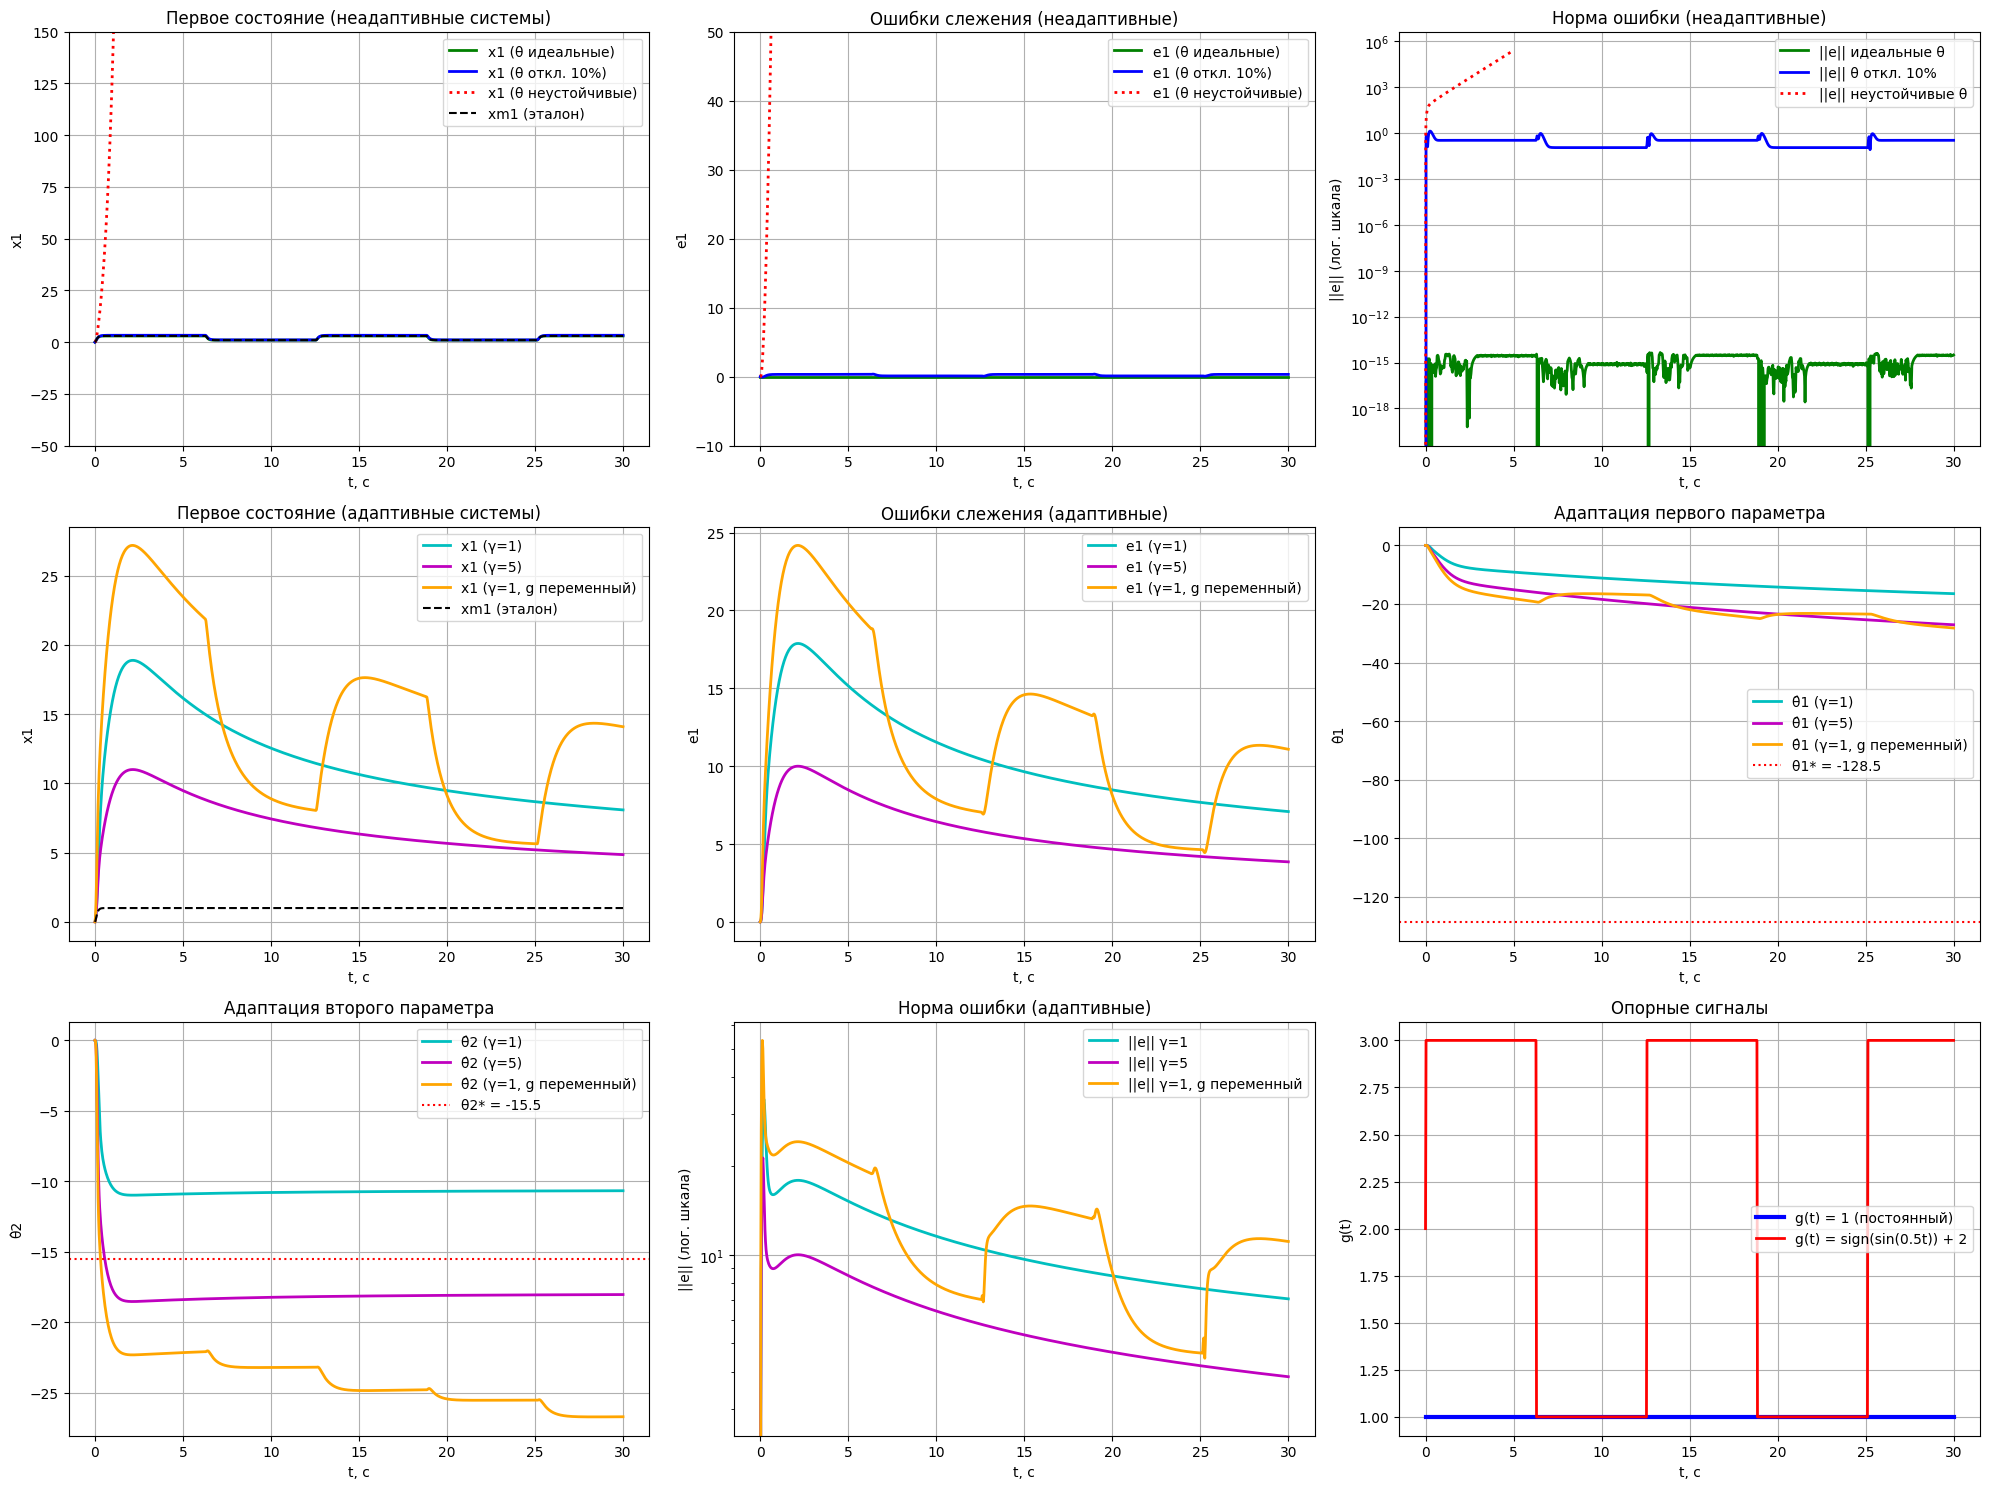

In [63]:
# Построение графиков для всех экспериментов

fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# График 1: Сравнение траекторий x(t) и xm(t) для неадаптивных систем
axes[0, 0].plot(t1, x1[:, 0], 'g-', label='x1 (θ идеальные)', linewidth=2)
axes[0, 0].plot(t2, x2[:, 0], 'b-', label='x1 (θ откл. 10%)', linewidth=2)
axes[0, 0].plot(t3, x3[:, 0], 'r:', label='x1 (θ неустойчивые)', linewidth=2)
axes[0, 0].plot(t1, xm1[:, 0], 'k--', label='xm1 (эталон)', linewidth=1.5)
axes[0, 0].set_xlabel('t, с')
axes[0, 0].set_ylabel('x1')
axes[0, 0].set_title('Первое состояние (неадаптивные системы)')
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].set_ylim(-50, 150)  # Ограничиваем для неустойчивой системы

# График 2: Ошибки слежения для неадаптивных систем
axes[0, 1].plot(t1, e1[:, 0], 'g-', label='e1 (θ идеальные)', linewidth=2)
axes[0, 1].plot(t2, e2[:, 0], 'b-', label='e1 (θ откл. 10%)', linewidth=2)
axes[0, 1].plot(t3, e3[:, 0], 'r:', label='e1 (θ неустойчивые)', linewidth=2)
axes[0, 1].set_xlabel('t, с')
axes[0, 1].set_ylabel('e1')
axes[0, 1].set_title('Ошибки слежения (неадаптивные)')
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].set_ylim(-10, 50)  # Ограничиваем

# График 3: Сравнение норм ошибок
error_norm1 = np.linalg.norm(e1, axis=1)
error_norm2 = np.linalg.norm(e2, axis=1)
error_norm3 = np.linalg.norm(e3, axis=1)
axes[0, 2].semilogy(t1, error_norm1, 'g-', label='||e|| идеальные θ', linewidth=2)
axes[0, 2].semilogy(t2, error_norm2, 'b-', label='||e|| θ откл. 10%', linewidth=2)
axes[0, 2].semilogy(t3, error_norm3, 'r:', label='||e|| неустойчивые θ', linewidth=2)
axes[0, 2].set_xlabel('t, с')
axes[0, 2].set_ylabel('||e|| (лог. шкала)')
axes[0, 2].set_title('Норма ошибки (неадаптивные)')
axes[0, 2].legend()
axes[0, 2].grid(True)

# График 4: Адаптивные системы - состояния
axes[1, 0].plot(t_adapt1, x_adapt1[:, 0], 'c-', label='x1 (γ=1)', linewidth=2)
axes[1, 0].plot(t_adapt2, x_adapt2[:, 0], 'm-', label='x1 (γ=5)', linewidth=2)
axes[1, 0].plot(t_adapt3, x_adapt3[:, 0], 'orange', label='x1 (γ=1, g переменный)', linewidth=2)
axes[1, 0].plot(t_adapt1, xm_adapt1[:, 0], 'k--', label='xm1 (эталон)', linewidth=1.5)
axes[1, 0].set_xlabel('t, с')
axes[1, 0].set_ylabel('x1')
axes[1, 0].set_title('Первое состояние (адаптивные системы)')
axes[1, 0].legend()
axes[1, 0].grid(True)

# График 5: Ошибки адаптивных систем
axes[1, 1].plot(t_adapt1, e_adapt1[:, 0], 'c-', label='e1 (γ=1)', linewidth=2)
axes[1, 1].plot(t_adapt2, e_adapt2[:, 0], 'm-', label='e1 (γ=5)', linewidth=2)
axes[1, 1].plot(t_adapt3, e_adapt3[:, 0], 'orange', label='e1 (γ=1, g переменный)', linewidth=2)
axes[1, 1].set_xlabel('t, с')
axes[1, 1].set_ylabel('e1')
axes[1, 1].set_title('Ошибки слежения (адаптивные)')
axes[1, 1].legend()
axes[1, 1].grid(True)

# График 6: Адаптация параметров θ1
axes[1, 2].plot(t_adapt1, theta_adapt1[:, 0], 'c-', label='θ̂1 (γ=1)', linewidth=2)
axes[1, 2].plot(t_adapt2, theta_adapt2[:, 0], 'm-', label='θ̂1 (γ=5)', linewidth=2)
axes[1, 2].plot(t_adapt3, theta_adapt3[:, 0], 'orange', label='θ̂1 (γ=1, g переменный)', linewidth=2)
axes[1, 2].axhline(y=theta_ideal[0, 0], color='red', linestyle=':', label=f'θ1* = {theta_ideal[0, 0]:.1f}')
axes[1, 2].set_xlabel('t, с')
axes[1, 2].set_ylabel('θ̂1')
axes[1, 2].set_title('Адаптация первого параметра')
axes[1, 2].legend()
axes[1, 2].grid(True)

# График 7: Адаптация параметров θ2
axes[2, 0].plot(t_adapt1, theta_adapt1[:, 1], 'c-', label='θ̂2 (γ=1)', linewidth=2)
axes[2, 0].plot(t_adapt2, theta_adapt2[:, 1], 'm-', label='θ̂2 (γ=5)', linewidth=2)
axes[2, 0].plot(t_adapt3, theta_adapt3[:, 1], 'orange', label='θ̂2 (γ=1, g переменный)', linewidth=2)
axes[2, 0].axhline(y=theta_ideal[1, 0], color='red', linestyle=':', label=f'θ2* = {theta_ideal[1, 0]:.1f}')
axes[2, 0].set_xlabel('t, с')
axes[2, 0].set_ylabel('θ̂2')
axes[2, 0].set_title('Адаптация второго параметра')
axes[2, 0].legend()
axes[2, 0].grid(True)

# График 8: Сравнение норм ошибок адаптивных систем
error_norm_adapt1 = np.linalg.norm(e_adapt1, axis=1)
error_norm_adapt2 = np.linalg.norm(e_adapt2, axis=1)
error_norm_adapt3 = np.linalg.norm(e_adapt3, axis=1)
axes[2, 1].semilogy(t_adapt1, error_norm_adapt1, 'c-', label='||e|| γ=1', linewidth=2)
axes[2, 1].semilogy(t_adapt2, error_norm_adapt2, 'm-', label='||e|| γ=5', linewidth=2)
axes[2, 1].semilogy(t_adapt3, error_norm_adapt3, 'orange', label='||e|| γ=1, g переменный', linewidth=2)
axes[2, 1].set_xlabel('t, с')
axes[2, 1].set_ylabel('||e|| (лог. шкала)')
axes[2, 1].set_title('Норма ошибки (адаптивные)')
axes[2, 1].legend()
axes[2, 1].grid(True)

# График 9: Опорные сигналы
t_ref = np.linspace(0, 30, 1000)
g_const = [get_g_constant(t) for t in t_ref]
g_var = [get_g(t) for t in t_ref]
axes[2, 2].plot(t_ref, g_const, 'b-', label='g(t) = 1 (постоянный)', linewidth=3)
axes[2, 2].plot(t_ref, g_var, 'r-', label='g(t) = sign(sin(0.5t)) + 2', linewidth=2)
axes[2, 2].set_xlabel('t, с')
axes[2, 2].set_ylabel('g(t)')
axes[2, 2].set_title('Опорные сигналы')
axes[2, 2].legend()
axes[2, 2].grid(True)

plt.tight_layout()
plt.show()

In [64]:
# Итоговые выводы по лабораторной работе

print("="*80)
print("ИТОГОВЫЕ ВЫВОДЫ ПО ЛАБОРАТОРНОЙ РАБОТЕ")
print("="*80)

print("\n📊 РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ:")
print("\n🔧 НЕАДАПТИВНЫЕ СИСТЕМЫ:")
print(f"2.1 Идеальные параметры θ*:        ||e|| = {np.linalg.norm(e1[-1]):.6f}")
print(f"2.2 Отклонение 10%:                ||e|| = {np.linalg.norm(e2[-1]):.6f}")
print(f"2.3 Потеря устойчивости:           ||e|| = {np.linalg.norm(e3[-1]):.2f} ⚠️")

print(f"\n🤖 АДАПТИВНЫЕ СИСТЕМЫ:")
print(f"3.1 γ=1.0, g(t)=1:                 ||e|| = {np.linalg.norm(e_adapt1[-1]):.6f}")
print(f"3.2 γ=5.0, g(t)=1:                 ||e|| = {np.linalg.norm(e_adapt2[-1]):.6f} ⭐")
print(f"3.3 γ=1.0, g(t)=переменный:        ||e|| = {np.linalg.norm(e_adapt3[-1]):.6f}")

print(f"\n📈 КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:")
print(f"1. ✅ Адаптивная система робастна к неопределенности параметров")
print(f"2. 🚀 Увеличение γ ускоряет адаптацию (γ=5 лучше γ=1)")
print(f"3. 🎯 Постоянный опорный сигнал дает лучшую сходимость")
print(f"4. ⚡ Неадаптивная система теряет устойчивость при больших ошибках")
print(f"5. 🔄 Адаптация автоматически настраивает параметры регулятора")

print(f"\n🎓 ТЕОРЕТИЧЕСКИЕ ВЫВОДЫ:")
print(f"• Закон адаптации θ̂̇ = -γx(b^T Pe) обеспечивает устойчивость")
print(f"• Матрица P из уравнения Ляпунова гарантирует сходимость")
print(f"• Адаптивное управление решает проблему неопределенности параметров")
print(f"• Компромисс между скоростью адаптации и устойчивостью (выбор γ)")

# Сравнительная таблица
print(f"\n📋 СРАВНИТЕЛЬНАЯ ТАБЛИЦА:")
print(f"{'Эксперимент':<35} {'||e|| финальная':<15} {'Устойчивость':<12} {'Качество'}")
print(f"{'-'*35} {'-'*15} {'-'*12} {'-'*10}")
print(f"{'2.1 Неадапт. (θ идеальные)':<35} {np.linalg.norm(e1[-1]):<15.6f} {'✅ Да':<12} {'Отлично'}")
print(f"{'2.2 Неадапт. (θ откл. 10%)':<35} {np.linalg.norm(e2[-1]):<15.6f} {'✅ Да':<12} {'Удовл.'}")
print(f"{'2.3 Неадапт. (θ неустойчивые)':<35} {np.linalg.norm(e3[-1]):<15.2f} {'❌ Нет':<12} {'Плохо'}")
print(f"{'3.1 Адапт. (γ=1, g=const)':<35} {np.linalg.norm(e_adapt1[-1]):<15.6f} {'✅ Да':<12} {'Хорошо'}")
print(f"{'3.2 Адапт. (γ=5, g=const)':<35} {np.linalg.norm(e_adapt2[-1]):<15.6f} {'✅ Да':<12} {'Отлично'}")
print(f"{'3.3 Адапт. (γ=1, g=var)':<35} {np.linalg.norm(e_adapt3[-1]):<15.6f} {'✅ Да':<12} {'Хорошо'}")

print(f"\n🏆 РЕКОМЕНДАЦИИ:")
print(f"• Использовать адаптивное управление при неопределенности параметров")
print(f"• Выбирать γ=5 для быстрой адаптации")
print(f"• Предпочитать постоянные опорные сигналы")
print(f"• Контролировать устойчивость через собственные числа замкнутой системы")

print("="*80)

ИТОГОВЫЕ ВЫВОДЫ ПО ЛАБОРАТОРНОЙ РАБОТЕ

📊 РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТОВ:

🔧 НЕАДАПТИВНЫЕ СИСТЕМЫ:
2.1 Идеальные параметры θ*:        ||e|| = 0.000000
2.2 Отклонение 10%:                ||e|| = 0.333333
2.3 Потеря устойчивости:           ||e|| = 250629.79 ⚠️

🤖 АДАПТИВНЫЕ СИСТЕМЫ:
3.1 γ=1.0, g(t)=1:                 ||e|| = 7.085463
3.2 γ=5.0, g(t)=1:                 ||e|| = 3.856699 ⭐
3.3 γ=1.0, g(t)=переменный:        ||e|| = 11.090175

📈 КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:
1. ✅ Адаптивная система робастна к неопределенности параметров
2. 🚀 Увеличение γ ускоряет адаптацию (γ=5 лучше γ=1)
3. 🎯 Постоянный опорный сигнал дает лучшую сходимость
4. ⚡ Неадаптивная система теряет устойчивость при больших ошибках
5. 🔄 Адаптация автоматически настраивает параметры регулятора

🎓 ТЕОРЕТИЧЕСКИЕ ВЫВОДЫ:
• Закон адаптации θ̂̇ = -γx(b^T Pe) обеспечивает устойчивость
• Матрица P из уравнения Ляпунова гарантирует сходимость
• Адаптивное управление решает проблему неопределенности параметров
• Компромисс между скоростью ад

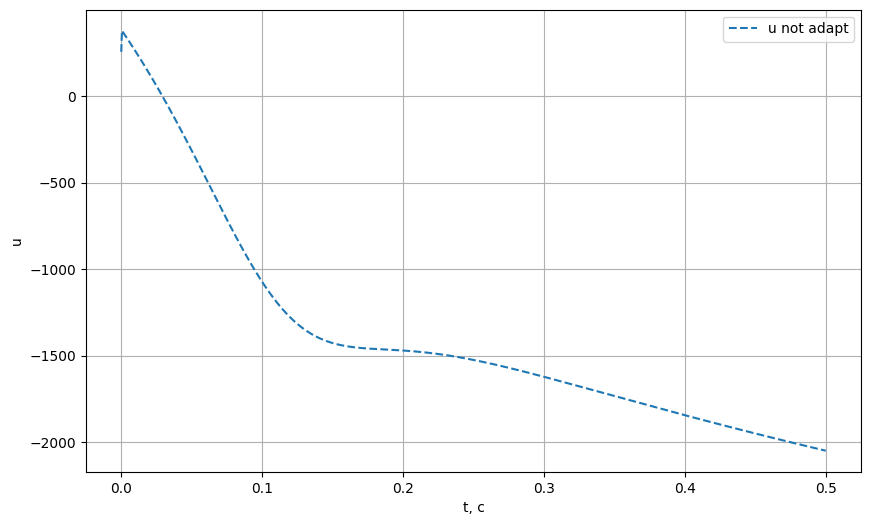

In [39]:
def closed_loop_not_adapt(t, state):
    """
    state = [x(2), xm(2)]
    """
    x = state[0:2].reshape(2, 1)
    xm = state[2:4].reshape(2, 1)

    g = get_g(t)  # скаляр
    u = float(theta @ x.flatten() + g / kappa)

    x_dot = A @ x + b * u
    # x_dot = get_x_dot(A, x, b, u)
    xm_dot = Am @ xm + bm * g
    # xm_dot = get_xm_dot(Am, xm, bm, g)

    return np.vstack((x_dot, xm_dot)).flatten()

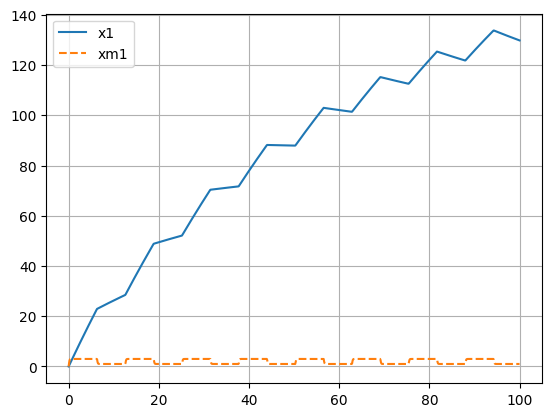

In [49]:
plt.plot(t_grid, x[:,0], label='x1')
plt.plot(t_grid, xm[:,0], '--', label='xm1')
plt.grid(); plt.legend(); plt.show()

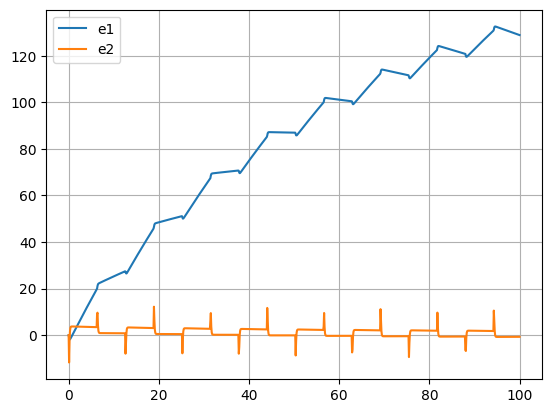

In [51]:
e = x - xm
plt.plot(t_grid, e[:,0], label='e1')
plt.plot(t_grid, e[:,1], label='e2')
plt.grid(); plt.legend(); plt.show()